# Understanding factors contributing to missing medical appointments: 
## An experience from Brazil

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this section of the report, provide a brief introduction to the medical appointment no-show dataset. This dataset collects information over the span of two months over about 100,000 medical appointments and contains data regarding demographics, some of the medical conditions that patients are affected with, as well as geosocial data, such as where the clinic or hospital is located, and whether patients get financial incentives as part of a Brazilian social aid program called 'Bolsa Familia'. There is also information regarding the date of the appointment and when the patient called to make the appointment. 

We will analyze how the rate of no-shows (i.e. missing appointments) is impacted by demographic and medical (age, sex, medical conditions), or geosocial characteristics (i.e. having financial aid, living or traveling to a particular neighborhood). We will also investigate how the rate of no-shows change by day of the week. This data could help clinics and hospitals better schedule their activities, by suiting them to a particular population (e.g. pediatrics, women, elderly) and by maximizing resources when patients are more likely to show up. They could also provide more help to those who may have barriers to attending their appointments. 

Let's get started!

In [38]:
#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

% matplotlib inline
sns.set(palette= 'Set2')

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In this section we explore the data and get to know it better. There are 110527 appointments and 14 features. 
From a brief look, we can see that there are no missing data and no duplicate entries. However the names of the columns appear to be a bit off, and we can improve on them in the next section to enhance clarity. 

In the following cells, we have printed off some pandas functions to survey the data a bit more closely. 

In [2]:
# Loading data and print the first 5 rows:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
#From here we see that there are no missing values. Patient ID has been encoded as a float
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


### Data Cleaning: making columns clearer and exploring duplicate entries

We notice some typos in the column names, which we can fix to make things easier to modify. 

In [4]:
df.columns = ['patientID', 'appointmentID', 'gender', 'scheduled_day',
       'appointment_day', 'age', 'neighborhood', 'scholarship', 'hypertension',
       'diabetes', 'alcoholism', 'disability', 'text_message', 'no_show']

We also see that categorical and date-time variables are encoded as strings. We will modify this now to make sure that analysis can be performed on those variables later on. 

In [5]:
df['appointment_day'] = pd.to_datetime(df['appointment_day'])
df['scheduled_day'] = pd.to_datetime(df['scheduled_day'])


df['scheduled_day'] = df.scheduled_day.dt.strftime("%Y-%m-%d")
df['scheduled_day'] = pd.to_datetime(df['scheduled_day'])

In [6]:
#We will rename the no_show column to make it clearer whether the patient showed up or not
#We will also change this to a numerical value
df.rename(columns = {'no_show': 'showed_up'}, inplace=True)
#Note values are inverted as we are flipping the meaning of the column :)
df['showed_up'].replace('No', 1, inplace=True) 
df['showed_up'].replace('Yes', 0, inplace=True) 


#Also changing gender to 0/1 as it will likely be useful in the future: 0 is M and 1 is F
df['gender'].replace('F', 1, inplace=True)
df['gender'].replace('M', 0, inplace=True)
df.head(2)

,patientID,appointmentID,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,disability,text_message,showed_up
0,2.987250e+13,5642903,1,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1
1,5.589978e+14,5642503,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1


In [7]:
#general statistics and overview of data
df.describe()

,patientID,appointmentID,gender,age,scholarship,hypertension,diabetes,alcoholism,disability,text_message,showed_up
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,0.649977,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.798067
std,2.560949e+14,7.129575e+04,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444
min,3.921784e+04,5.030230e+06,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.173184e+13,5.680573e+06,1.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,9.439172e+13,5.725524e+06,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.999816e+14,5.790484e+06,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


> in the above table, we see that ages are not clearly plausible. Age -1 would not be possible. Also there appears to be a maximum age of 115. Those are both worth exploring better. 

In [8]:
#Look at outlier ages: age of -1
df[df.age == -1]

,patientID,appointmentID,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,disability,text_message,showed_up
99832,4.659432e+14,5775010,1,2016-06-06,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,1


There is only one entry with age of -1, so it makes sense to remove this entry

In [9]:
#Remove the row with the age '-1'
df.drop(99832, inplace = True)

In [10]:
#Look at outlier ages: age of 115
df[df.age == 115]

,patientID,appointmentID,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,disability,text_message,showed_up
63912,3.196321e+13,5700278,1,2016-05-16,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,0
63915,3.196321e+13,5700279,1,2016-05-16,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,0
68127,3.196321e+13,5562812,1,2016-04-08,2016-05-16,115,ANDORINHAS,0,0,0,0,1,0,0
76284,3.196321e+13,5744037,1,2016-05-30,2016-05-30,115,ANDORINHAS,0,0,0,0,1,0,1
97666,7.482346e+14,5717451,1,2016-05-19,2016-06-03,115,SÃO JOSÉ,0,1,0,0,0,1,1


Looking at this part of the dataframe, we notice two points: 
1. There are few extreme ages: by definition, these are 'super-centenerians', as they have lived to or passed their 110th birthday. While these could be valid entries, looking over the internet [link (https://en.wikipedia.org/wiki/List_of_supercentenarians_by_continent#South_American_supercentenarians)], there are not that many supercentenarians in South America, especially Brazil, who have lived to 114 or 115. Based on this, and the fact that these are just 5 entries, I decided to remove them from the dataframe. 
2. In addition, we can notice the same person (3.196321e+13) has made multiple appointments and only attended one. This person appears to have two appointments on the same day (2016-05-19). These appointments have different appointment IDs. This duplicate was not captured earlier given that the appointmentID column entry is different. While you could have multiple appointments in a day, it would make sense that people that show up on an appointment that day would also show up to the other one, since it is in the same area. It is worth to explore this issue of multiple appointments with same ID further, after cleaning up the data of extreme values in age. 

In [11]:
#Dropping extreme ages
extreme_age = df[df.age == 115].index
df.drop(extreme_age, inplace=True)

In [12]:
#At first glance, no duplicates exist in the data
df[df.duplicated()]

,patientID,appointmentID,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,disability,text_message,showed_up


In [13]:
#We will drop the appointmentID column as it can cause potential duplicates to be missed. 
df.drop('appointmentID', axis = 1, inplace =True)

In [14]:
#We will now see how many duplicated there are in the dataset
df[df.duplicated()].count()

patientID          4221
gender             4221
scheduled_day      4221
appointment_day    4221
age                4221
neighborhood       4221
scholarship        4221
hypertension       4221
diabetes           4221
alcoholism         4221
disability         4221
text_message       4221
showed_up          4221
dtype: int64

> Not considering different appointment IDs, you can see that there are now several duplicates in this dataframe.
While the actual time on the appointment day is not specified and the patient could have had multiple appointments on the same day, those would be at the same place (given equality of the other columns). Since patient is / is not already there for each of these appointments (as they are indeed identical), it would appear redundant to include these patients for subsequent analysis, so we will drop them. 

In [15]:
df.drop(df[df.duplicated()].index, inplace=True)

In later parts of the analysis, we will be interested in wait times, i.e. amount of time patient has to wait from when they call to make an appointment to when they actually have the appointment (`appointment_day - scheduled_day`). 

In [16]:
df['wait_times'] = df.appointment_day - df.scheduled_day
df['wait_times'] = df['wait_times'].dt.days #changing format to days from datetimedelta

In [17]:
df.describe()

,patientID,gender,age,scholarship,hypertension,diabetes,alcoholism,disability,text_message,showed_up,wait_times
count,1.063000e+05,106300.000000,106300.000000,106300.000000,106300.000000,106300.000000,106300.000000,106300.000000,106300.000000,106300.000000,106300.000000
mean,1.467598e+14,0.654591,37.113556,0.098071,0.198946,0.072747,0.027987,0.021863,0.333706,0.795974,10.408617
std,2.551478e+14,0.475504,23.168804,0.297413,0.399209,0.259722,0.164936,0.160233,0.471539,0.402990,15.369464
min,3.921784e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
25%,4.151415e+12,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.154280e+13,1.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
75%,9.433654e+13,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,15.000000
max,9.999816e+14,1.000000,102.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,179.000000


Note how there are negative wait times recorded: this does not make sense, as `appointment_day` should be later in time than `scheduled_day`. We will investigate this further. 

In [18]:
df[df.wait_times < 0]

,patientID,gender,scheduled_day,appointment_day,age,neighborhood,scholarship,hypertension,diabetes,alcoholism,disability,text_message,showed_up,wait_times
27033,7.839273e+12,0,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,0,-1
55226,7.896294e+12,1,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,0,-1
64175,2.425226e+13,1,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,0,-1
71533,9.982316e+14,1,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,0,-6
72362,3.787482e+12,0,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,0,-1


In [19]:
#Only 6 values have negative wait times. We can safely remove those as well
df.drop(df[df.wait_times < 0].index, inplace=True)

In [20]:
#Dropping date appointment was made, as we will not be using that any more
df.drop('scheduled_day', axis = 1, inplace =True)

> Looking at the table more closely, it appears that some patients are showing up multiple times. This is reasonable as There are about 44,000 duplicates in the patientID columns. In other words, the same patients tend to make multiple appointments. Duplicate patient IDs represent about 41% of the datasets. Therefore, almost half of the entries are from a similar group of patients.
This could have an influence on the conclusions we draw, so we need to see that it does not sway the proportion of shows and no-shows too much. 

In [21]:
df.patientID[df.patientID.duplicated()].count()

43999

In [22]:
df.patientID[df.patientID.duplicated()].count() / df.shape[0]

0.41393292252692976

In [23]:
duplicated_ID = list(df.patientID[df.patientID.duplicated()])

In the next cell, I have included some code to determine whether patients who have several appointments are significantly swaying the data one way or the other.

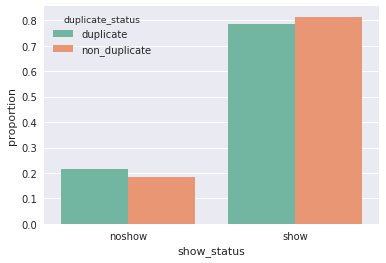

In [24]:
#Create separate variables for duplicates and rest of the patients (non_duplicates): 
x = df['showed_up'][df.patientID.duplicated()]

# For the non duplicated data, we are excluding all the people 
# who have more than one appointment in the system
df2 = df[~df.patientID.isin(duplicated_ID)] 
y = df2['showed_up']


#Get the proportion of noshows and shows for duplicates and non_duplicates
duplicate_data = {'noshow': (x[x == 0].count()/ x.count()), 'show': (x[x==1].count()/x.count())}
nonduplicate_data = {'noshow': (y[y== 0].count()/y.count()), 'show': (y[y== 1].count()/y.count())}

#Create a dataframe for each group
duplicate_df = pd.DataFrame.from_dict(duplicate_data, orient='index')
non_duplicate_df = pd.DataFrame.from_dict(nonduplicate_data, orient = 'index')
                                        

#Join the two dataframes together 
dup_nodup_df = pd.concat([duplicate_df, non_duplicate_df])
dup_nodup_df.reset_index(inplace=True)
dup_nodup_df['type'] = ['duplicate', 'duplicate', 'non_duplicate', 'non_duplicate']
dup_nodup_df.columns = ['show_status', 'proportion', 'duplicate_status']

#Create a plot showing proportion for shows and noshows for duplicates and non_duplicates
ax = sns.barplot(x="show_status", y="proportion", hue = 'duplicate_status', data=dup_nodup_df);

> As shown in the bar plot above, there is not a big difference between shows and noshows between patients making manu apointments and those who only presented once. We will therefore keep these patients as they will make the sample size better. 
Moreover, we can notice here that the majority show up to their appointments, in both groups.

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### General descriptive statistics

In [25]:
df.describe()

,patientID,gender,age,scholarship,hypertension,diabetes,alcoholism,disability,text_message,showed_up,wait_times
count,1.062950e+05,106295.000000,106295.000000,106295.000000,106295.000000,106295.000000,106295.000000,106295.000000,106295.000000,106295.000000,106295.000000
mean,1.467569e+14,0.654593,37.113731,0.098076,0.198956,0.072750,0.027988,0.021845,0.333722,0.796011,10.409201
std,2.551391e+14,0.475503,23.168661,0.297419,0.399217,0.259728,0.164940,0.160181,0.471544,0.402963,15.369584
min,3.921784e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.151415e+12,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.154399e+13,1.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
75%,9.433654e+13,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,15.000000
max,9.999816e+14,1.000000,102.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,179.000000


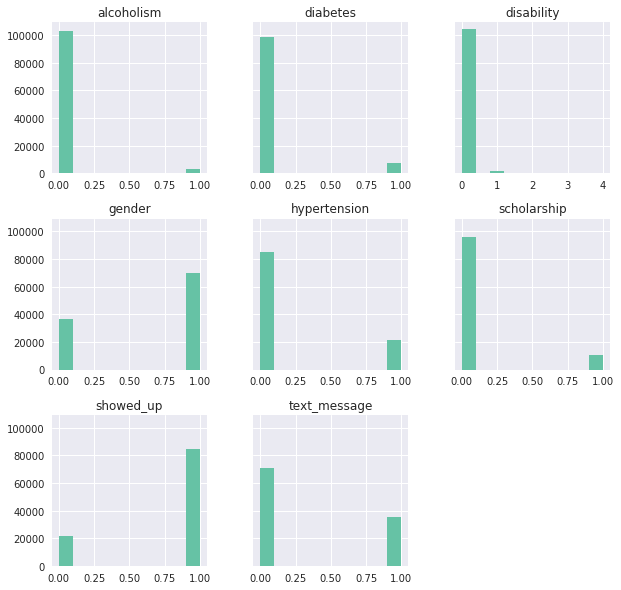

In [26]:
col = ['gender', 'scholarship', 'hypertension', 'alcoholism', 'diabetes','disability', 'text_message', 'showed_up']
df.hist(column=col, figsize = (10, 10), sharey = True);

Looking over the data, we see the majority of patients are female, and the majority showed up to the appointment. Most of the people do not have any disease or disability. 

However, there is about a quarter of this sample who has hypertension and about 10% has diabetes. The majority of people did not receive a reminder text message. 

We see that younger population is more abundant in this dataset, with a high number of infants and a good amount of young adults. Beyond the age of 60, the population starts to get more and more scant, with only a small amount of centenarians.  We also notice that the population is not normally distributed.

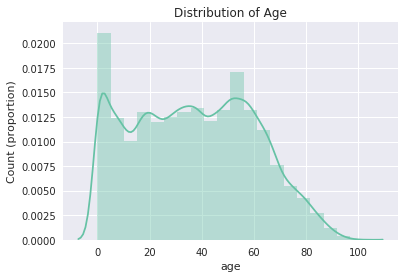

In [27]:
#fig = plt.figure()
ax = sns.distplot(df.age, bins =20);
plt.title('Distribution of Age')
plt.ylabel('Count (proportion)');

### Temporal trends
#### Is the rate of showing up to appointments higher during a day of the week?
Knowing whether there is a difference in number of noshows for a day of the week may have importance in that it could help direct future scheduling efforts, by opening up more availabilities when people are more likely to show up and by reducing efforts when people do not show up. 

In [112]:
df['weekday'] = df.appointment_day.dt.strftime('%A')
by_date = df.groupby('weekday')['showed_up'].mean()
by_date = pd.DataFrame(by_date)
by_date.reset_index(inplace=True)
#Sorting values based on day of the week
by_date['weekday'] = pd.Categorical(by_date['weekday'], 
                                    categories= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], 
                                    ordered = True)
                                    
by_date.sort_values(by='weekday', inplace = True)
by_date

,weekday,showed_up
1,Monday,0.789944
4,Tuesday,0.797660
5,Wednesday,0.801064
3,Thursday,0.804490
0,Friday,0.786335
2,Saturday,0.769231


We can see that there is a bit less people showing up on Saturdays. The majority of people show up on Wednesdays. 
We are also interested to know if any relationship exists between wait times and proportion of attendance. 

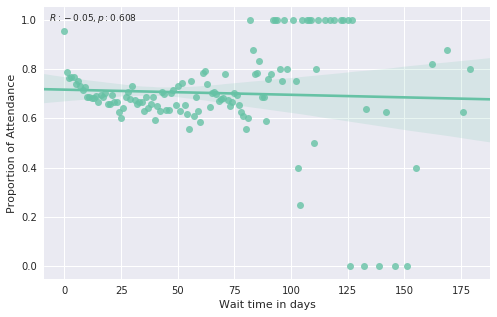

In [40]:
wait = df.groupby('wait_times')['showed_up'].mean()
fig2 = plt.figure(figsize=(8, 5))
R,p = pearsonr(wait.index, wait)
ax2 = sns.regplot(pd.Series(wait.index), wait)

#This part was obtained from https://stackoverflow.com/questions/54949755/seaborn-matplotlib-adding-text-relative-to-axes 
tl = ((ax2.get_xlim()[1] - ax2.get_xlim()[0])*0.010 + ax2.get_xlim()[0],
(ax2.get_ylim()[1] - ax2.get_ylim()[0])*0.95 + ax2.get_ylim()[0])
ax2.text(tl[0], tl[1], r"$R: {:.2f},    p:  {:.3f} $".format(R, p), fontsize=9)
##

plt.xlabel('Wait time in days')
plt.ylabel('Proportion of Attendance');

Overall we see the data is quite sparse. There is no clear correlation between wait times and proportion of attendance. However, more consistently, people show up when appointments are made within 75 days, whereas beyond that point, there is quite a lot of variability with the proportion of those that don't show up increasing. 

### Does the no-show rate depend on any prior medical conditions or on demographic factors? 


### Medical conditions: 
As we see below, there is not much change in rate of appointment attendance based on some of the most common diseases (diabetes, hypertension, alcoholism), albeit a small trend towards greater attendance in those with hypertension and diabetes and slightly lower attendance in those with a history of alcohol abuse. 

There is an important pattern in the attendance rate of those with disabilities: patients who have mild or moderate disability show up more than those with more severe levels of disability. We could speculate that this may have to do with how poor their health is or to barriers to coming (e.g. unable to get out of the house). 

In [91]:
diabetes = df.groupby('diabetes')['showed_up'].mean()
hypertension = df.groupby('hypertension')['showed_up'].mean()
disability = df.groupby('disability')['showed_up'].mean()
alcoholism = df.groupby('alcoholism')['showed_up'].mean()


gender = df.groupby('gender')['showed_up'].mean()
age = df.groupby('age')['showed_up'].mean()
disease = pd.concat([diabetes, hypertension, alcoholism], axis = 0)
disease = pd.DataFrame(disease)
#disease.columns = ['diabetes', 'hypertension', 'alcohol']
disease.reset_index(inplace = True)
#disease.rename(columns = {'alcoholism' :'disease_present'}, inplace=True)
disease['medical_condition'] = ['diabetes', 'diabetes', 'hypertension', 'hypertension', 'alcohol', 'alcohol']
disease['presence_of_disease'] = ['No', 'Yes', 'No', 'Yes', 'No', 'Yes']

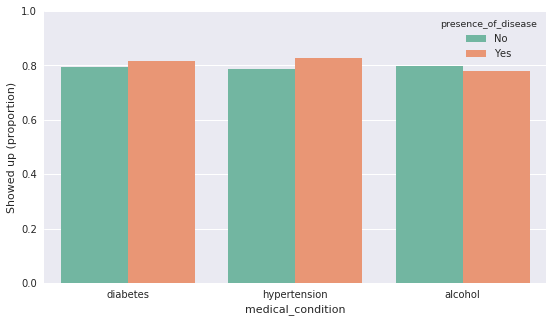

In [96]:
fig3 = plt.figure(figsize = (9, 5))
ax = sns.barplot(x = 'medical_condition', y = 'showed_up', hue = 'presence_of_disease', data = disease)
plt.ylim(0,1)
plt.ylabel('Showed up (proportion)');

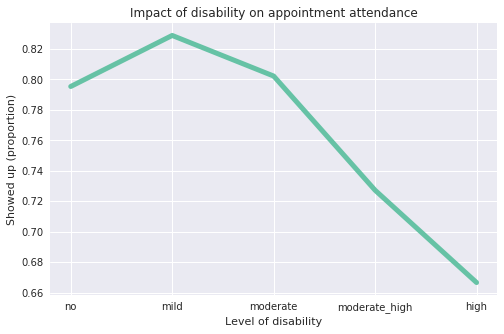

In [97]:
fig = plt.figure(figsize = (8,5))
plt.plot(disability, linewidth = 5)
plt.xticks([0,1,2,3,4], ['no', 'mild', 'moderate', 'moderate_high', 'high'])
plt.xlabel("Level of disability")
plt.ylabel("Showed up (proportion)")
plt.title('Impact of disability on appointment attendance');

### Demographics: 

we see a reduction in rate of attendance to medical appointments in the young-adult population. 
The rate of attendance increases with increasing ages, with the exception of a drop in the very elderly between aged of 90 and 100. As we saw, there is only a few centenaries in this population, and those few elderly tend to show up.  since these are outliers, I have removed them from the plot. 

We also see that males are more likely to show up than females. 

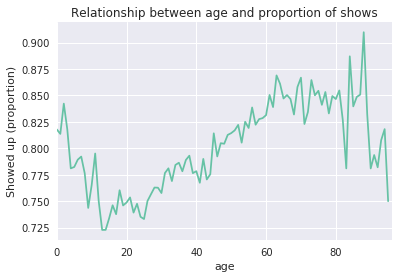

In [98]:
plt.plot(age.loc[0: 95])
plt.title("Relationship between age and proportion of shows")
plt.xlim(0, 96)
plt.xlabel('age')
plt.ylabel("Showed up (proportion)");

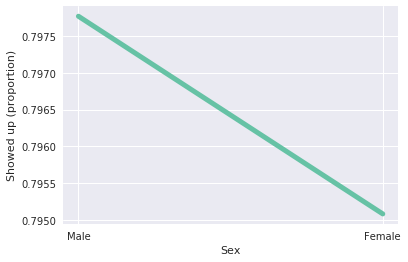

In [99]:
plt.plot(gender, linewidth = 5)
plt.xticks([0, 1], ['Male', 'Female'])
plt.xlabel('Sex')
plt.ylabel("Showed up (proportion)");

### Do geosocial factors have an impact on no shows?

Scholarships are ...
Oftentimes different neighborhoods may have different social backgrounds, different access to transportation, different economic classes. We want to see whether provenance from different neighborhoods has an impact on being able to make it to a medical appointment. 

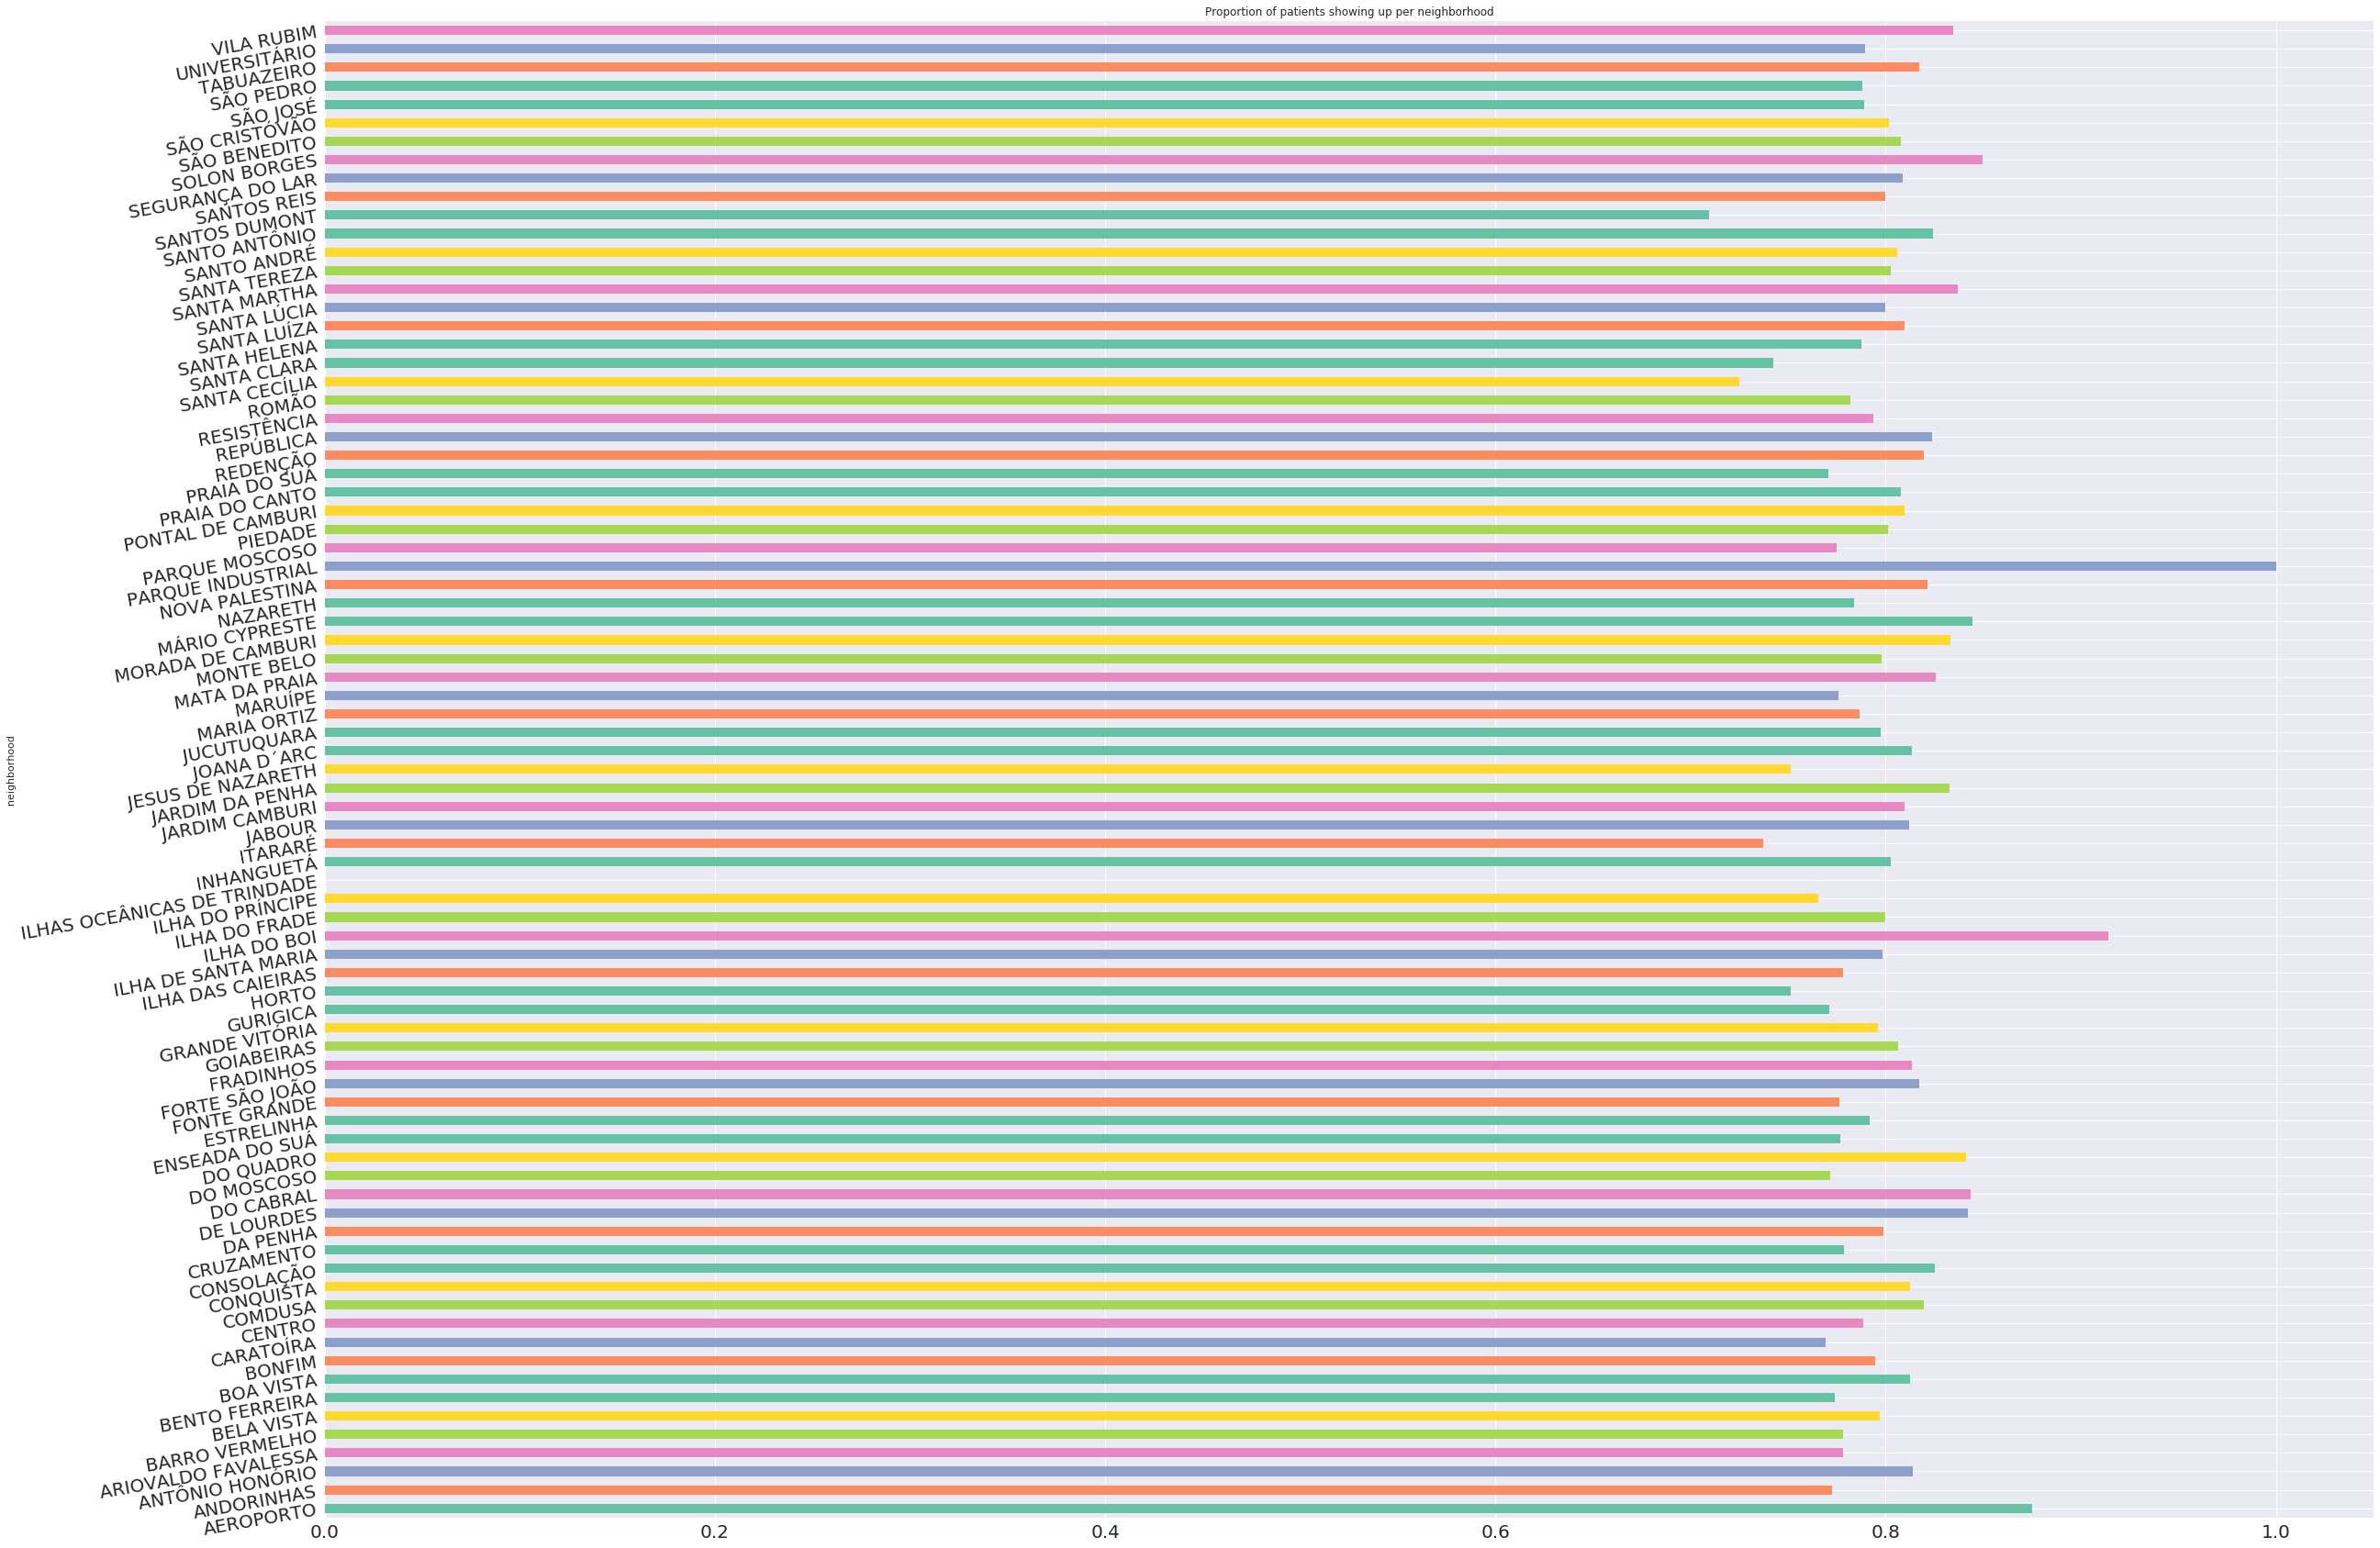

In [100]:
neighbor = df.groupby('neighborhood')['showed_up'].mean()
neighbor.plot(kind='barh', figsize=(40,30), fontsize = 20, rot=10,
              title= 'Proportion of patients showing up per neighborhood');

In [101]:
allshows = neighbor[neighbor == 1.0].index[0]
noshows = neighbor[neighbor == 0.0].index[0]
print("Neighborhood with 100% show up rate: {}.\nNeighborhood with 0% showup rate: {}.".format(allshows, noshows))

print("Total number of appointments were {} and {}, respectively".format(
      df.groupby('neighborhood')['showed_up'].count()['PARQUE INDUSTRIAL'], 
      df.groupby('neighborhood')['showed_up'].count()['ILHAS OCEÂNICAS DE TRINDADE']))

Neighborhood with 100% show up rate: PARQUE INDUSTRIAL.
Neighborhood with 0% showup rate: ILHAS OCEÂNICAS DE TRINDADE.
Total number of appointments were 1 and 2, respectively


In [102]:
scholarship_mean = df.groupby('scholarship')['showed_up'].mean()
scholarship_mean

scholarship
0    0.799802
1    0.761151
Name: showed_up, dtype: float64

We see that overall there is not much difference in show-up rates across neighborhoods, with the exception of Parque Industrial, where everyone showed up and Trinidade Island, where nobody showed up. Of notice, very few appointments were made there, so that may not be representative of the true population in those neighborhoods. 

Having a scholarship does not impact the overall proportion of appointment attendance.

<a id='conclusions'></a>
## Conclusions

We have analyzed a dataset containing information about medical appointments made in Brazil and what relationships exist between several demographic, social, economical, and medical factors and the rate of medical appointment attendance. 

We see that this population is mainly composed of females, and that overall the majority of the patients attend their appointments. We see that there is a higher proportion of attendance in males and in the elderly and in those with no or mild disability. Those with hypertension or diabetes may tend to attend slightly more and those with alcoholism tend to miss slightly more appointments. 

There is not much difference in attendance rates between those who have social financial incentives and people generally tend to attend to their appointments regardless of the neighborhood where the hospital or clinic is located. 

### Limitations
 - Throughout the analysis we saw that part of the categories, such as the centenerians or the number of appointment made in certain neighborhoods are low, and therefore we cannot derive any certain conclusions from that. There is a large group of the sample that has more than one appointment, although the presence of these individuals does not appear to sway the data significantly.
 
- About 4000 datapoints were duplicated (same patient ID, same appointment day) and had to be removed during the data cleaning process. This reduces the sample size by about 4% and could therefore impact the validity of some of the analysis. 

- We do not know whether this sample is representative of the whole population, especially if considering it by neighborhood: many neighborhoods only had few entries (e.g. the Island of Trinidade), and as such we cannot necessarily draw solid conclusions for each of the neighborhoods or the Brazilian population as a whole. 


- When analyzing wait times, we have sparser data for longer wait times, this can make drawing conclusions more difficult in this part of the analysis. In fact, we do not have information as to the urgency of the visit. We do not have a way to know whether same-day appointments are such just because of availability or because they were urgent. If an appointment was for urgent reasons, the patient would be most likely to show up. Similarly, we do not know therefore if the appointments that were scheduled several months ahead were intentional (e.g. a 6 month follow up) or where because of other reasons (e.g. clinic was not available).

- Education levels for the population (or the caregivers in case of young children or the elderly) were not available, and this could be an important factor to keep in mind. 

- We may not have enough information on an important category of patients: those with great disabilities (e.g. levels 3 and 4 in this dataset). These patients typically require more medical care. However, they represent only a minority of this dataset, so we may not see their needs and their health care utilization well with this analysis. Further studies aimed at this population could be helpful in the future. 

In [103]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0